In [1]:
#now we have a few files to work with:

# 0xLead_FullParaffin.tsv /

# 0xLead_HalfParaffin_LLD42.tsv /

# 0xLead_HalfParaffin_LLD71.tsv /

# 1xLead_FullCarbon.tsv

# 1xLead_FullParaffin.tsv /

# 1xLead_HalfParaffin.tsv /

# 2xLead.tsv /

# 2xLead_FullCarbon.tsv 

# 2xLead_FullParaffin.tsv /

# 2xLead_HalfCarbon.tsv

# 2xLead_HalfParaffin.tsv /

# so now we have "full lead with either full, half, or no paraffin", "half lead with full or half paraffin",
# and "no lead with full and half paraffin"
# then 3 other datasets for carbon as a sort of control

# let's start by comparing all of the full lead ones and see which has the best peaks

<ErrorbarContainer object of 3 artists>

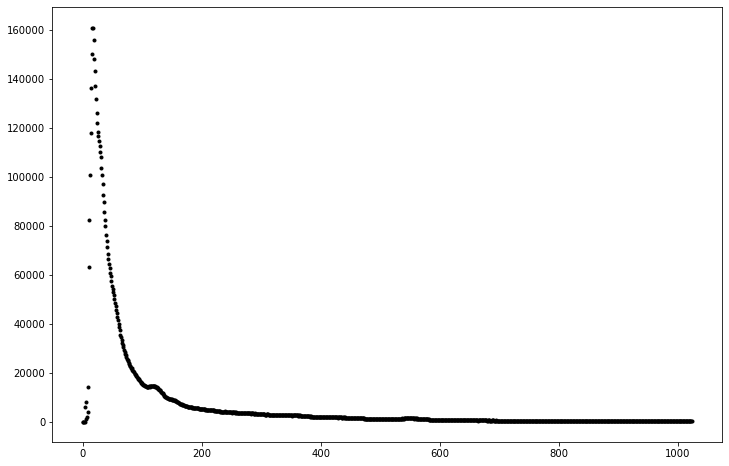

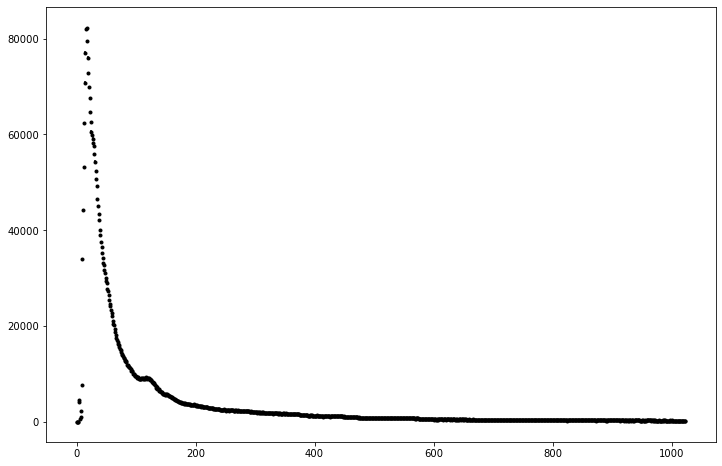

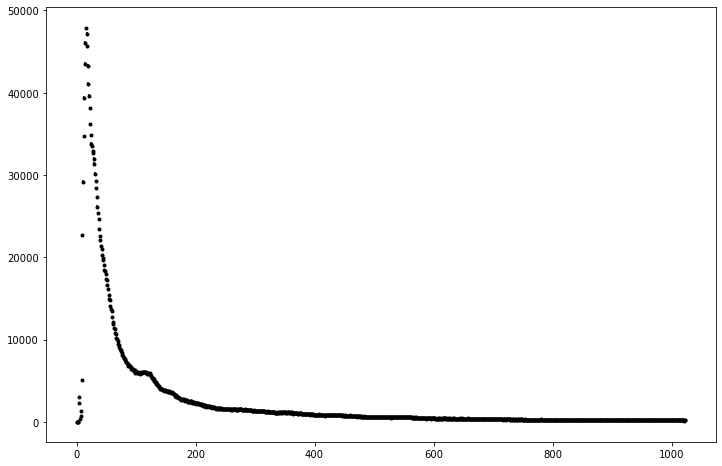

In [35]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

#data = np.loadtxt(tsv_file, delimiter="\t", skiprows=1, usecols=[0,1,2])

data_start = 22

lead2_full_paraffin = "2xLead_FullParaffin.tsv"
lead2_half_paraffin = "2xLead_HalfParaffin.tsv"
lead2_no_paraffin = "2xLead.tsv"

l2_fp = np.loadtxt( lead2_full_paraffin , unpack=True, skiprows = data_start, delimiter = "\t\t") 
l2_hp = np.loadtxt( lead2_half_paraffin , unpack=True, skiprows = data_start, delimiter = "\t\t") 
l2_np = np.loadtxt( lead2_no_paraffin , unpack=True, skiprows = data_start, delimiter = "\t\t") 


channel_l2_fp = l2_fp[0]
N_l2_fp = l2_fp[1]
dN_l2_fp = np.sqrt(N_l2_fp)
for i, value in enumerate(dN_l2_fp):
    if value == 0:
        dN_l2_fp[i] = 1.14
        
channel_l2_hp = l2_hp[0]
N_l2_hp = l2_hp[1]
dN_l2_hp = np.sqrt(N_l2_hp)
for i, value in enumerate(dN_l2_hp):
    if value == 0:
        dN_l2_hp[i] = 1.14
        
channel_l2_np = l2_np[0]
N_l2_np = l2_np[1]
dN_l2_np = np.sqrt(N_l2_np)
for i, value in enumerate(dN_l2_np):
    if value == 0:
        dN_l2_np[i] = 1.14
        
fig,ax = plt.subplots(figsize = (12,8))
ax.errorbar(channel_l2_fp, N_l2_fp, dN_l2_fp, fmt='k.')

fig,ax = plt.subplots(figsize = (12,8))
ax.errorbar(channel_l2_hp, N_l2_hp, dN_l2_hp, fmt='k.')

fig,ax = plt.subplots(figsize = (12,8))
ax.errorbar(channel_l2_np, N_l2_np, dN_l2_np, fmt='k.')

<ErrorbarContainer object of 3 artists>

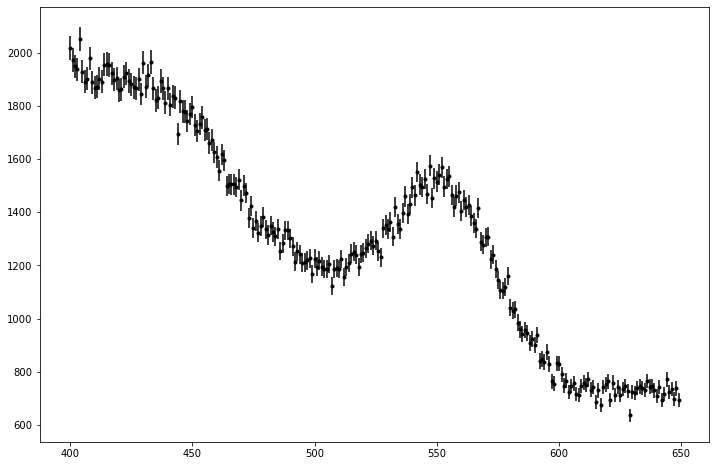

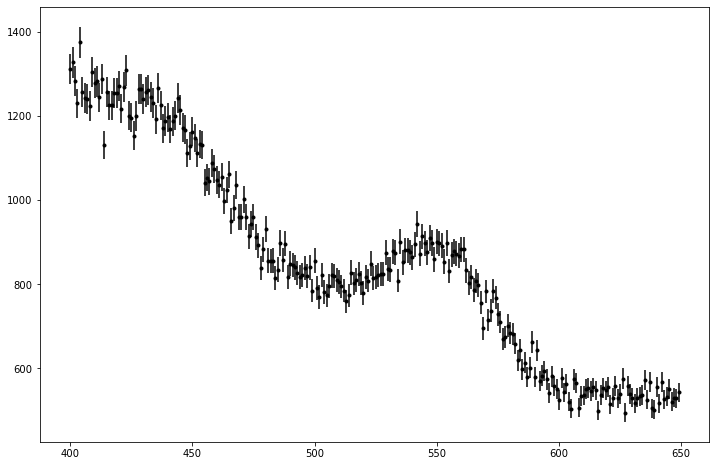

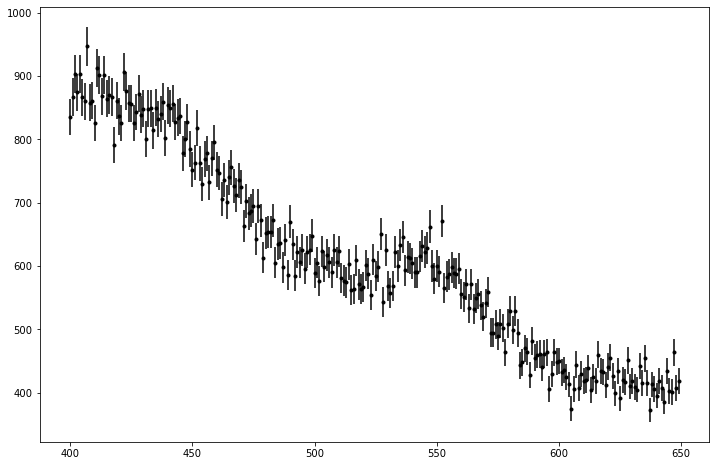

In [8]:
# now we narrow these down to our region of interest, which we can assume is between 400 and 600, to look for perturbations

min_value = 400
max_value = 650

fig,ax = plt.subplots(figsize = (12,8))
ax.errorbar(channel_l2_fp[min_value:max_value], N_l2_fp[min_value:max_value], dN_l2_fp[min_value:max_value], fmt='k.')

fig,ax = plt.subplots(figsize = (12,8))
ax.errorbar(channel_l2_hp[min_value:max_value], N_l2_hp[min_value:max_value], dN_l2_hp[min_value:max_value], fmt='k.')

fig,ax = plt.subplots(figsize = (12,8))
ax.errorbar(channel_l2_np[min_value:max_value], N_l2_np[min_value:max_value], dN_l2_np[min_value:max_value], fmt='k.')

<ErrorbarContainer object of 3 artists>

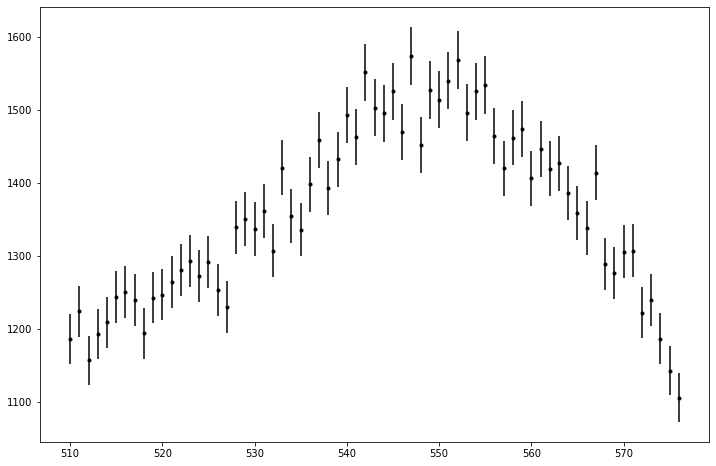

In [36]:
# there is a clear perturbation for the one with more paraffin.  We can use this to estimate the gamma.  it will likely
# eventually make more sense to subtract from the no paraffin trial, after some other considerations.

min_value = 510
max_value = 577

fig,ax = plt.subplots(figsize = (12,8))
ax.errorbar(channel_l2_fp[min_value:max_value], N_l2_fp[min_value:max_value], dN_l2_fp[min_value:max_value], fmt='k.')

In [38]:
def gaussianfunc_lin(p,x):
    return p[0]/(p[2]*np.sqrt(2*np.pi))*np.exp(-(x-p[1])**2/(2*p[2]**2)) + p[3]*x +p[4]

def residual(p,func, xvar, yvar, err):
    return (func(p, xvar) - yvar)/err

#channel_T1_0, N_T1_0, dN_T1_0

# The code below defines our data fitting function.
# Inputs are:
# initial guess for parameters p0
# the function we're fitting to
# the x,y, and dy variables
# tmi can be set to 1 or 2 if more intermediate data is needed

def data_fit(p0,func,xvar, yvar, err,tmi=0):
    try:
        fit = optimize.least_squares(residual, p0, args=(func,xvar, yvar, err),verbose=tmi)
    except Exception as error:
        print("Something has gone wrong:",error)
        return p0,np.zeros_like(p0),-1,-1
    pf = fit['x']

    print()

    try:
        cov = np.linalg.inv(fit['jac'].T.dot(fit['jac']))          
        # This computes a covariance matrix by finding the inverse of the Jacobian times its transpose
        # We need this to find the uncertainty in our fit parameters
    except:
        # If the fit failed, print the reason
        print('Fit did not converge')
        print('Result is likely a local minimum')
        print('Try changing initial values')
        print('Status code:', fit['status'])
        print(fit['message'])
        return pf,np.zeros_like(pf),-1,-1
            #You'll be able to plot with this, but it will not be a good fit.

    chisq = sum(residual(pf,func,xvar, yvar, err) **2)
    dof = len(xvar) - len(pf)
    red_chisq = chisq/dof
    pferr = np.sqrt(np.diagonal(cov)) # finds the uncertainty in fit parameters by squaring diagonal elements of the covariance matrix
    print('Converged with chi-squared {:.2f}'.format(chisq))
    print('Number of degrees of freedom, dof = {:.2f}'.format(dof))
    print('Reduced chi-squared {:.2f}'.format(red_chisq))
    print()
    Columns = ["Parameter #","Initial guess values:", "Best fit values:", "Uncertainties in the best fit values:"]
    print('{:<11}'.format(Columns[0]),'|','{:<24}'.format(Columns[1]),"|",'{:<24}'.format(Columns[2]),"|",'{:<24}'.format(Columns[3]))
    for num in range(len(pf)):
        print('{:<11}'.format(num),'|','{:<24.3e}'.format(p0[num]),'|','{:<24.3e}'.format(pf[num]),'|','{:<24.3e}'.format(pferr[num]))
    return pf, pferr, chisq,dof

In [39]:
channel_l2_fp_2= channel_l2_fp[min_value:max_value]
N_l2_fp_2 = N_l2_fp[min_value:max_value]
dN_l2_fp_2 = dN_l2_fp[min_value:max_value]

p0 = [3.076e+04 , 5.542e+02, 2.061e+01, -5.172e+00, 3.779e+03]

pf1, pferr1, chisq1, dof1 = data_fit(p0,gaussianfunc_lin, channel_l2_fp_2, N_l2_fp_2, dN_l2_fp_2)



Converged with chi-squared 54.99
Number of degrees of freedom, dof = 62.00
Reduced chi-squared 0.89

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 3.076e+04                | 3.076e+04                | 1.165e+04               
1           | 5.542e+02                | 5.542e+02                | 2.283e+00               
2           | 2.061e+01                | 2.061e+01                | 3.039e+00               
3           | -5.172e+00               | -5.172e+00               | 2.202e+00               
4           | 3.779e+03                | 3.779e+03                | 1.084e+03               


In [40]:
# so now we have our best guess for where the gamma is/in which channel:

gamma_channel = pf1[1]
gamma_channel_err = pferr1[1]

print(gamma_channel)
print(gamma_channel_err)

554.1757517285226
2.2831416786759813


In [41]:
# now we take our values from the calibration and we find:

# y = int_ch + sl_ch (x)

# energy = (gamma_channel) - int_ch \ sl_ch

intercept_ev_vs_channel = 0.4883023468821541

slope_ev_vs_channel = 0.00025361427529895165

gamma_energy_ev = ( gamma_channel - intercept_ev_vs_channel ) / slope_ev_vs_channel

print(gamma_energy_ev)

2183187.2386874636


In [45]:
# this yields a value of 2.1831872386874633385 MeV

# now we can get started on synthesizing the rest of the data making sure we carry uncertainties, etc.

rest_mass_proton_kg = 1.67262*(10)**(-27)

print(rest_mass_proton_kg)

c = 2.998 * 10**8

energy_proton_joules = rest_mass_proton_kg * (c)**2
print(energy_proton_joules)
energy_proton_ev = 938318258.97915316

rest_mass_deuterium = 3.3443254* (10)**(-27)

energy_deuterium_joules = rest_mass_deuterium * (c)**2
print(energy_deuterium_joules)

energy_deuterium_ev = 1876123439.148018837

# now we have n + p = d + g so n = d + g - p via conservation of energy

neutron_energy_ev = ( energy_deuterium_ev + gamma_energy_ev ) - energy_proton_ev

print("neutron energy ev: ")

print(neutron_energy_ev)

neutron_energy_joules = 1.506027333632991691 * (10)**(-10) 

mass_neutron_kg = neutron_energy_joules / (c)**2
print("mass of neutron in kg: ")
print(mass_neutron_kg)

1.6726200000000002e-27
1.503351525048e-10
3.0058810072501596e-10
neutron energy ev: 
939988367.4075532
mass of neutron in kg: 
1.675597088778545e-27


In [ ]:
# accepted neutron mass: 1.6749286E-27 kg
# carry uncertainties
# how to show it is truly significant: difference in net count and uncertainty
# need to find statistical significance by doing 2 sigmas between diff datasets
# it is 5 sigma for particle phys, like 2 for those silly social sciences\

# want to first prove that the deuteron and gamma comes from proton and neutron
# interaction and exclude the possibility that paraffin is radioactive.

